In [3]:
import gc
import os
import time
import datetime
import warnings
from itertools import combinations
from warnings import simplefilter

import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error 
warnings.filterwarnings('ignore')
simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [23]:
class CFG:
    """
    Configuration class for parameters and CV strategy for tuning and training
    Please use caps lock capital letters while filling in parameters
    """
    
    # Data preparation
    version_nb         = 3
    is_gpu             = True
    # device             = torch.device('cuda' if torch.cuda.is_available() and gpu_switch else 'cpu')
    state              = 42
    num_workers        = 4

    # BEFORE SUBMIT, CHECK SETTINGS
    is_test_mode       = True
    test_mode_frac     = 20
    is_offline         = True
    testing_days       = 2

    target             = 'target'    
    path               = '/kaggle/input/optiver-trading-at-the-close'
    train_path         = f'{path}/train.csv'
    test_path          = f'{path}/example_test_files/test.csv'
    model_path         = f'' if not is_offline else f'{path}/'
    
    TRAINING           = True
    INFERENCE          = False
    TUNING             = True
    
    methods            = ['LGBM',]
    # methods            = ['CBT']

    plt_path = f'fig/turning'

# Data Loading and Preprocessing 






In [5]:
# 📂 Read the dataset from a CSV file using Pandas
df = pd.read_csv(CFG.train_path)
if CFG.is_test_mode:
    df = df[df['stock_id'] < CFG.test_mode_frac]

# 🧹 Remove rows with missing values in the "target" column
df = df.dropna(subset=['target'])

# 🔁 Reset the index of the DataFrame and apply the changes in place
df.reset_index(drop=True, inplace=True)

# 📏 Get the shape of the DataFrame (number of rows and columns)
df_shape = df.shape
print(df_shape)

(529099, 17)


# Memory Optimization

In [6]:
def reduce_mem_usage(df, verbose=0):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
               
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)
    if verbose:
        logger.info(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        logger.info(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        logger.info(f"Decreased by {decrease:.2f}%")
    return df


 # Parallel Triplet Imbalance Calculation

In [7]:
from numba import njit, prange

@njit(parallel=True)
def compute_triplet_imbalance(df_values, comb_indices):
    num_rows = df_values.shape[0]
    num_combinations = len(comb_indices)
    imbalance_features = np.empty((num_rows, num_combinations))
    for i in prange(num_combinations):
        a, b, c = comb_indices[i]
        for j in range(num_rows):
            max_val = max(df_values[j, a], df_values[j, b], df_values[j, c])
            min_val = min(df_values[j, a], df_values[j, b], df_values[j, c])
            mid_val = df_values[j, a] + df_values[j, b] + df_values[j, c] - min_val - max_val
            
            if mid_val == min_val:
                imbalance_features[j, i] = np.nan
            else:
                imbalance_features[j, i] = (max_val - mid_val) / (mid_val - min_val)

    return imbalance_features

def calculate_triplet_imbalance_numba(price, df):
    df_values = df[price].values
    comb_indices = [(price.index(a), price.index(b), price.index(c)) for a, b, c in combinations(price, 3)]
    features_array = compute_triplet_imbalance(df_values, comb_indices)
    columns = [f"{a}_{b}_{c}_imb2" for a, b, c in combinations(price, 3)]
    features = pd.DataFrame(features_array, columns=columns)
    return features


# Feature Generation Functions 

In [8]:
def imbalance_features(df):
    # Define lists of price and size-related column names
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
    df["volume"] = df.eval("ask_size + bid_size")
    df["mid_price"] = df.eval("(ask_price + bid_price) / 2")
    df["liquidity_imbalance"] = df.eval("(bid_size-ask_size)/(bid_size+ask_size)")
    df["matched_imbalance"] = df.eval("(imbalance_size-matched_size)/(matched_size+imbalance_size)")
    df["size_imbalance"] = df.eval("bid_size / ask_size")
    df["size_imbalance_bid"] = df.eval("imbalance_size / bid_size")
    df["size_imbalance_ask"] = df.eval("imbalance_size / ask_size")
    df["matched_size_bid_ask"] = df.eval("matched_size / (bid_size+ask_size)")

    for c in combinations(prices, 2):
        df[f"{c[0]}_{c[1]}_imb"] = df.eval(f"({c[0]} - {c[1]})/({c[0]} + {c[1]})")

    for c in [['ask_price', 'bid_price', 'wap', 'reference_price'], sizes]:
        triplet_feature = calculate_triplet_imbalance_numba(c, df)
        df[triplet_feature.columns] = triplet_feature.values
   
    df["imbalance_momentum"] = df.groupby(['stock_id'])['imbalance_size'].diff(periods=1) / df['matched_size']
    df["price_spread"] = df["ask_price"] - df["bid_price"]
    df["spread_intensity"] = df.groupby(['stock_id'])['price_spread'].diff()
    df['price_pressure'] = df['imbalance_size'] * (df['ask_price'] - df['bid_price'])
    df['market_urgency'] = df['price_spread'] * df['liquidity_imbalance']
    df['depth_pressure'] = (df['ask_size'] - df['bid_size']) * (df['far_price'] - df['near_price'])
    
    # Calculate various statistical aggregation features
    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices_{func}"] = df[prices].agg(func, axis=1)
        df[f"all_sizes_{func}"] = df[sizes].agg(func, axis=1)
        

    for col in ['matched_size', 'imbalance_size', 'reference_price', 'imbalance_buy_sell_flag']:
        for window in [1, 2, 3, 10]:
            df[f"{col}_shift_{window}"] = df.groupby('stock_id')[col].shift(window)
            df[f"{col}_ret_{window}"] = df.groupby('stock_id')[col].pct_change(window)

            if window == 1:
                continue

            date_ids = df['date_id'].unique()
            agg_func = ['mean', 'sum']
            moving_li = []
            
            for date in date_ids:
                moving_li.append(
                    df[df['date_id'] == date].groupby('stock_id')[col].rolling(window).agg(agg_func).reset_index().set_index('level_1')[agg_func]
                )
            df[[f'{col}_moving_average_{window}', f'{col}_moving_sum_{window}']] = pd.concat(moving_li)[agg_func]
    
    # Calculate diff features for specific columns
    for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size', 'market_urgency', 'imbalance_momentum', 'size_imbalance']:
        for window in [1, 2, 3, 10]:
            df[f"{col}_diff_{window}"] = df.groupby("stock_id")[col].diff(window)

    # --- add
    # Calculate diff prices
    for c in combinations(prices, 2):
        df[f'{c[0]}_{c[1]}_diff'] = df.eval(f'({c[0]} - {c[1]})')

    return df.replace([np.inf, -np.inf], 0)

def other_features(df):
    df["dow"] = df["date_id"] % 5  # Day of the week
    df["seconds"] = df["seconds_in_bucket"] % 60  
    df["minute"] = df["seconds_in_bucket"] // 60  
    for key, value in global_stock_id_feats.items():
        df[f"global_{key}"] = df["stock_id"].map(value.to_dict())

    return df

def generate_all_features(df, feature_name=None):
    # Select relevant columns for feature generation
    cols = [c for c in df.columns if c not in ["row_id", "time_id", "target"]]
    df = df[cols]
    
    # Generate imbalance features
    df = imbalance_features(df)
    df = other_features(df)
    gc.collect()

    if not feature_name:
        feature_name = [i for i in df.columns if i not in ["row_id", "target", "time_id", "date_id", 'ask_price_bid_price_diff']]
    
    return df[feature_name]

In [9]:
weights = [
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
]
weights = {int(k):v for k,v in enumerate(weights)}

## Data Splitting

In [10]:
# from sklearn.model_selection import GroupShuffleSplit 

# splitter = GroupShuffleSplit(test_size=.20, n_splits=1, random_state=CFG.state)
# split = splitter.split(df, groups=df['stock_id'])
# train_inds, test_inds = next(split)

# df_train = df.iloc[train_inds].copy()
# df_test = df.iloc[test_inds].copy()
number_of_days = len(df['date_id'].unique())
training_days = number_of_days - CFG.testing_days
train_inds = df['date_id'] <= training_days
test_inds = df['date_id'] > training_days

df_train = df[train_inds]
df_test = df[test_inds]
del df, train_inds, test_inds

In [11]:
feature_name = ['reference_price_ask_price_imb',
 'bid_size',
 'matched_size_moving_average_10',
 'far_price_near_price_imb',
 'near_price_wap_diff',
 'all_sizes_kurt',
 'near_price_bid_price_imb',
 'near_price_wap_imb',
 'matched_size_moving_average_2',
 'mid_price',
 'size_imbalance_ask',
 'imbalance_buy_sell_flag_moving_average_2',
 'near_price',
 'reference_price_wap_diff',
 'wap',
 'global_median_price',
 'all_prices_skew',
 'imbalance_size_ret_3',
 'ask_price_bid_price_imb',
 'all_sizes_mean',
 'bid_price_wap_imb',
 'global_ptp_price',
 'bid_price_diff_10',
 'global_ptp_size',
 'matched_imbalance',
 'matched_size_ret_1',
 'imbalance_buy_sell_flag_moving_average_10',
 'global_std_price',
 'reference_price_ret_1',
 'reference_price_bid_price_imb',
 'ask_price_bid_price_wap_imb2',
 'imbalance_buy_sell_flag_shift_10',
 'global_std_size',
 'imbalance_buy_sell_flag_shift_1',
 'size_imbalance',
 'market_urgency_diff_1',
 'global_median_size',
 'reference_price_bid_price_diff',
 'all_sizes_std',
 'market_urgency',
 'stock_id',
 'imbalance_size_ret_10',
 'reference_price_near_price_diff',
 'reference_price_moving_average_10',
 'reference_price_moving_average_3',
 'ask_size',
 'ask_price_bid_price_reference_price_imb2',
 'imbalance_momentum',
 'ask_price_diff_3',
 'all_prices_kurt',
 'ask_price_diff_1',
 'reference_price_wap_imb',
 'spread_intensity',
 'far_price_near_price_diff',
 'ask_price_diff_10',
 'matched_size_bid_size_imbalance_size_imb2',
 'ask_price',
 'all_prices_std',
 'imbalance_buy_sell_flag',
 'matched_size_shift_3',
 'reference_price',
 'near_price_ask_price_diff',
 'reference_price_shift_10',
 'price_spread',
 'matched_size_ret_10',
 'bid_price_diff_1',
 'matched_size_moving_average_3',
 'imbalance_size_shift_3',
 'matched_size_ret_3',
 'imbalance_size_moving_average_10',
 'market_urgency_diff_2',
 'market_urgency_diff_3',
 'dow',
 'price_pressure',
 'bid_price',
 'imbalance_size',
 'bid_price_diff_2',
 'near_price_ask_price_imb',
 'all_prices_mean',
 'imbalance_size_shift_10',
 'all_sizes_skew',
 'far_price',
 'imbalance_buy_sell_flag_moving_average_3',
 'ask_price_diff_2',
 'ask_price_wap_reference_price_imb2',
 'near_price_bid_price_diff',
 'bid_price_diff_3',
 'bid_price_wap_reference_price_imb2',
 'imbalance_size_ret_2',
 'matched_size_bid_ask',
 'reference_price_ask_price_diff',
 'matched_size_shift_10',
 'matched_size_ask_size_imbalance_size_imb2',
 'reference_price_ret_10',
 'imbalance_size_moving_average_3',
 'imbalance_size_ret_1',
 'imbalance_size_moving_average_2',
 'market_urgency_diff_10',
 'seconds_in_bucket']

In [12]:
global_stock_id_feats = {
    "median_size": df_train.groupby("stock_id")["bid_size"].median() + df_train.groupby("stock_id")["ask_size"].median(),
    "std_size": df_train.groupby("stock_id")["bid_size"].std() + df_train.groupby("stock_id")["ask_size"].std(),
    "ptp_size": df_train.groupby("stock_id")["bid_size"].max() - df_train.groupby("stock_id")["bid_size"].min(),
    "median_price": df_train.groupby("stock_id")["bid_price"].median() + df_train.groupby("stock_id")["ask_price"].median(),
    "std_price": df_train.groupby("stock_id")["bid_price"].std() + df_train.groupby("stock_id")["ask_price"].std(),
    "ptp_price": df_train.groupby("stock_id")["bid_price"].max() - df_train.groupby("stock_id")["ask_price"].min(),
}

if CFG.TRAINING:
    df_train_feats = generate_all_features(df_train, feature_name)
    df_train_feats = reduce_mem_usage(df_train_feats)

    df_test_feats = generate_all_features(df_test, feature_name)
    df_test_feats = reduce_mem_usage(df_test_feats)

    feature_name = list(df_train_feats.columns)
    print(f'Feature length = {len(feature_name)}')

    train_target = df_train['target']
    test_target = df_test['target']

Feature length = 99


In [13]:
# The total number of date_ids is 480, we split them into 5 folds with a gap of 5 days in between
num_folds = 5
fold_size = df_train['date_id'].max() // num_folds
gap = 5
folds = []

# We need to use the date_id from df_train to split the data
date_ids = df_train['date_id'].values

for i in range(num_folds):
    start = i * fold_size
    end = start + fold_size
    
    # Define the training and testing sets by date_id
    if i < num_folds - 1:  # No need to purge after the last fold
        purged_start = end - 2
        purged_end = end + gap + 2
        train_indices = (date_ids >= start) & (date_ids < purged_start) | (date_ids > purged_end)
    else:
        train_indices = (date_ids >= start) & (date_ids < end)
    
    test_indices = (date_ids >= end) & (date_ids < end + fold_size)
    folds.append((train_indices, test_indices))

del date_ids, df_train, df_test, train_indices, test_indices
gc.collect()
print(fold_size)

95


In [14]:
# import sys

# print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
# print(" ------------------------------------ ")
# for var_name in dir():
#     if not var_name.startswith("_"):
#         print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

## LightGBM

In [24]:
import lightgbm as lgb
# 使用するチューニング対象外のパラメータ
params = {
    'objective': 'mae',  # 最小化させるべき損失関数
    'metric': 'mae',  # 学習時に使用する評価指標(early_stoppingの評価指標にも同じ値が使用される)
    'random_state': CFG.state,  # 乱数シード
    'boosting_type': 'gbdt',  # boosting_type
    'n_estimators': 10000 if CFG.is_test_mode else 500,
    'early_stopping_round': 50 if CFG.is_test_mode else 10,  # ここでearly_stoppingを指定
    'verbose': -1,
    'importance_type': 'gain',
    # 'n_jobs': CFG.num_workers,
    'device': 'gpu' if CFG.is_gpu else 'cpu',
}
# モデル作成
model = lgb.LGBMRegressor(**params)
# 学習時fitパラメータ指定 (early_stopping用のデータeval_setを渡す)
fit_params = {
    'eval_set': [(df_test_feats, test_target)],
    'callbacks': [lgb.callback.log_evaluation(period=-1),],
}
scoring = 'neg_mean_absolute_error'  # 評価指標をRMSEに指定

## TUNING

In [16]:
from sklearn.model_selection import cross_val_score
# クロスバリデーションで評価指標算出
scores = cross_val_score(model, df_train_feats, train_target, cv=folds,
                         scoring=scoring, n_jobs=-1, fit_params=fit_params)
print(f'scores={scores}')
print(f'average_score={np.mean(scores)}')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


scores=[-6.97690177 -6.44228801 -6.25757898 -5.97796559 -5.37353159]
average_score=-6.20565318754846


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtyp

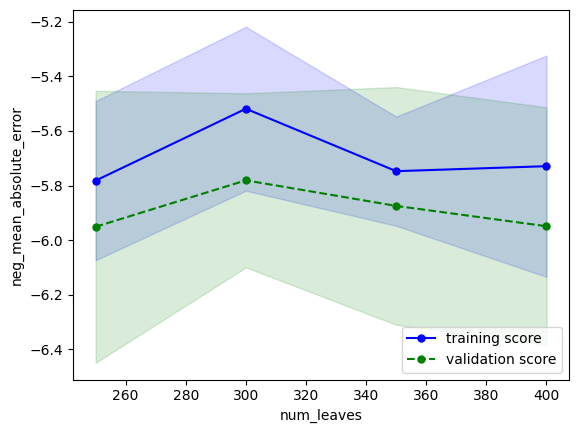

In [15]:
# %% 手順2) パラメータ種類と範囲の選択
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
cv_params = {
    # 'reg_alpha': [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
    # 'reg_lambda': [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
    # 'num_leaves': [2, 4, 8, 16, 32, 64, 96, 128, 160, 192, 224, 256],
    'num_leaves': [250, 300, 350, 400],
    # 'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], # max1
    # 'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  # max1
    # 'subsample_freq': [0, 1, 2, 3, 4, 5, 6, 7],
    # 'min_child_samples': [0, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}
param_scales = {
    'reg_alpha': 'log',
    'reg_lambda': 'log',
    'num_leaves': 'linear',
    'colsample_bytree': 'linear',
    'subsample': 'linear',
    'subsample_freq': 'linear',
    'min_child_samples': 'linear'
}
# model.set_params(min_child_samples=2, num_leaves=2)

# 検証曲線のプロット（パラメータ毎にプロット）
os.makedirs(f'{CFG.plt_path}/lgbm/', exist_ok=True)
for i, (k, v) in enumerate(cv_params.items()):
    train_scores, valid_scores = validation_curve(estimator=model,
                                                  X=df_train_feats, y=train_target,
                                                  param_name=k,
                                                  param_range=v,
                                                  fit_params=fit_params,
                                                  cv=folds, scoring=scoring,
                                                  n_jobs=-1)
    # 学習データに対するスコアの平均±標準偏差を算出
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    train_center = train_mean
    train_high = train_mean + train_std
    train_low = train_mean - train_std
    # テストデータに対するスコアの平均±標準偏差を算出
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std  = np.std(valid_scores, axis=1)
    valid_center = valid_mean
    valid_high = valid_mean + valid_std
    valid_low = valid_mean - valid_std
    # training_scoresをプロット
    plt.figure()
    plt.plot(v, train_center, color='blue', marker='o', markersize=5, label='training score')
    plt.fill_between(v, train_high, train_low, alpha=0.15, color='blue')
    # validation_scoresをプロット
    plt.plot(v, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
    plt.fill_between(v, valid_high, valid_low, alpha=0.15, color='green')
    # スケールをparam_scalesに合わせて変更
    plt.xscale(param_scales[k])
    # 軸ラベルおよび凡例の指定
    plt.xlabel(k)  # パラメータ名を横軸ラベルに
    plt.ylabel(scoring)  # スコア名を縦軸ラベルに
    plt.legend(loc='lower right')  # 凡例
    # グラフを描画
    # plt.show()
    plt.savefig(f'{CFG.plt_path}/lgbm/{k}_{scoring}.png')
    gc.collect()

In [25]:
# %% 手順3＆4) パラメータ選択＆クロスバリデーション（optunaでベイズ最適化）
import optuna
from sklearn.model_selection import cross_val_score
start = time.time()
# ベイズ最適化時の評価指標算出メソッド
def bayes_objective(trial):
    params = {
        'reg_alpha': trial.suggest_float('reg_alpha', 0.03, 0.3, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 250, 350),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
        # 'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        # 'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 30, 50)
    }
    # モデルにパラメータ適用
    model.set_params(**params)
    # cross_val_scoreでクロスバリデーション
    scores = cross_val_score(model, df_train_feats, train_target, cv=folds,
                             scoring=scoring, fit_params=fit_params, n_jobs=-1)
    val = scores.mean()
    return val

# ベイズ最適化を実行
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=CFG.state))
study.optimize(bayes_objective, n_trials=400)

# 最適パラメータの表示と保持
best_params = study.best_trial.params
best_score = study.best_trial.value
print(f'最適パラメータ {best_params}\nスコア {best_score}')
print(f'所要時間{time.time() - start}秒')

[I 2023-11-25 00:35:29,078] A new study created in memory with name: no-name-40e44aac-029b-460c-a1dd-2168a524bd88
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this ve

最適パラメータ {'reg_alpha': 0.11084064604345145, 'reg_lambda': 0.03566771917864813, 'num_leaves': 329, 'colsample_bytree': 0.8786516053175251, 'min_child_samples': 34}
スコア -5.69147215413203
所要時間12622.044343709946秒


In [16]:
# best_params = {'reg_alpha': 0.11084064604345145, 'reg_lambda': 0.03566771917864813, 'num_leaves': 329, 'colsample_bytree': 0.8786516053175251, 'min_child_samples': 34}
# 最適パラメータ {'reg_alpha': 0.11084064604345145, 'reg_lambda': 0.03566771917864813, 'num_leaves': 329, 'colsample_bytree': 0.8786516053175251, 'min_child_samples': 34}
# スコア -5.69147215413203
# 所要時間12622.044343709946秒

In [26]:
# %% 学習曲線のプロット
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
# 最適パラメータを学習器にセット
model.set_params(**best_params)

# 学習曲線の取得
train_sizes, train_scores, valid_scores = learning_curve(estimator=model,
                                                         X=df_train_feats, y=train_target,
                                                         train_sizes=np.linspace(0.1, 1.0, 10),
                                                         fit_params=fit_params,
                                                         cv=folds, scoring=scoring, n_jobs=-1)
# 学習データ指標の平均±標準偏差を計算
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
train_center = train_mean
train_high = train_mean + train_std
train_low = train_mean - train_std
# 検証データ指標の平均±標準偏差を計算
valid_mean = np.mean(valid_scores, axis=1)
valid_std  = np.std(valid_scores, axis=1)
valid_center = valid_mean
valid_high = valid_mean + valid_std
valid_low = valid_mean - valid_std
# training_scoresをプロット
plt.figure()
plt.plot(train_sizes, train_center, color='blue', marker='o', markersize=5, label='training score')
plt.fill_between(train_sizes, train_high, train_low, alpha=0.15, color='blue')
# validation_scoresをプロット
plt.plot(train_sizes, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
plt.fill_between(train_sizes, valid_high, valid_low, alpha=0.15, color='green')
# 最高スコアの表示
best_score = valid_center[len(valid_center) - 1]
plt.text(np.amax(train_sizes), valid_low[len(valid_low) - 1], f'best_score={best_score}',
                color='black', verticalalignment='top', horizontalalignment='right')
# 軸ラベルおよび凡例の指定
plt.xlabel('training examples')  # 学習サンプル数を横軸ラベルに
plt.ylabel(scoring)  # スコア名を縦軸ラベルに
plt.legend(loc='lower right')  # 凡例

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


IndexError: Boolean index has wrong length: 158399 instead of 527999

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


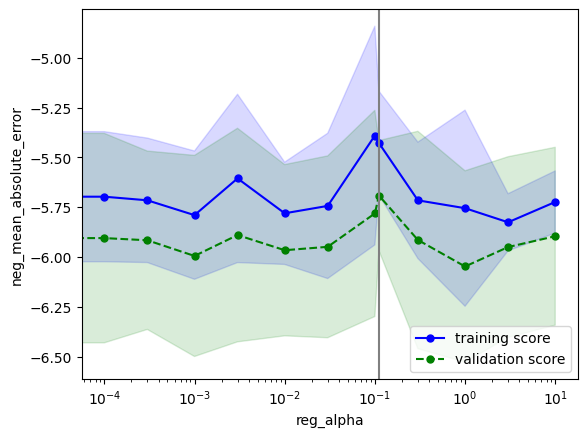

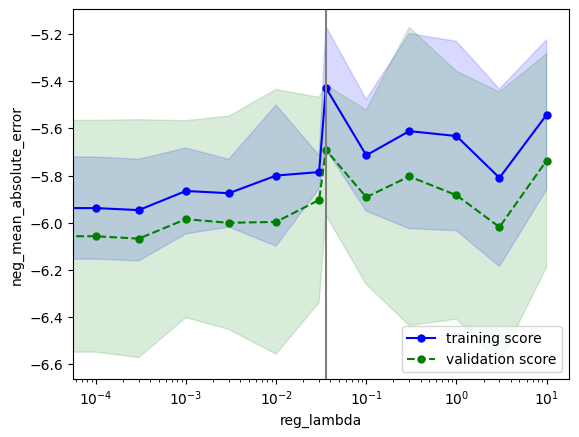

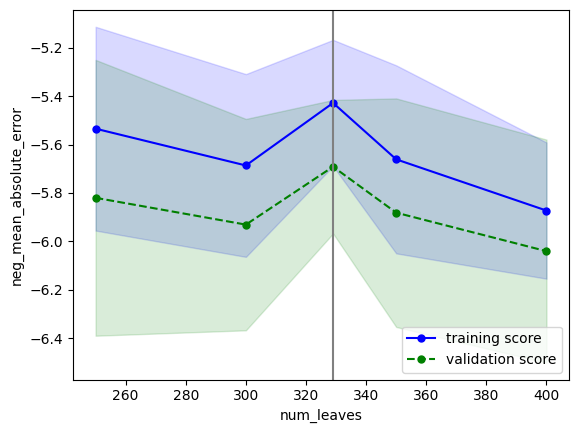

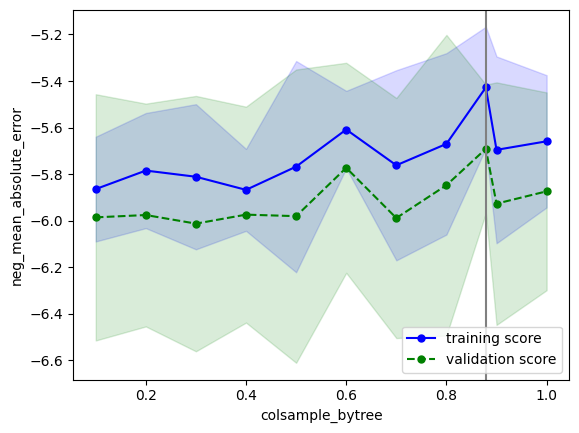

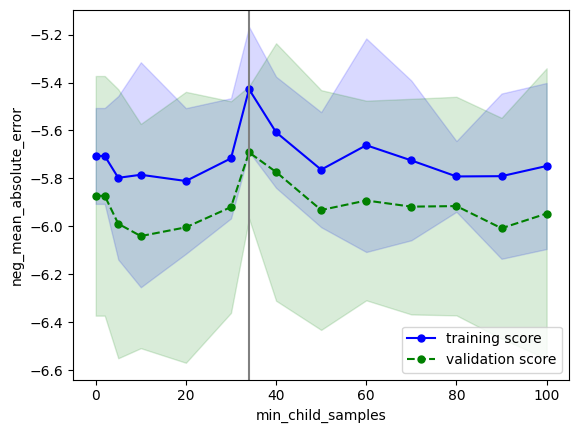

In [27]:
# %% 検証曲線のプロット（横軸パラメータ以外は最適値に固定）
from sklearn.model_selection import validation_curve
# 検証曲線描画対象パラメータ
valid_curve_params = {
    'reg_alpha': [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
    'reg_lambda': [0, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10],
    # 'num_leaves': [2, 4, 8, 16, 32, 64, 96, 128, 160, 192, 224, 256],
    'num_leaves': [250, 300, 350, 400],
    'colsample_bytree': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], # max1
    # 'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],  # max1
    # 'subsample_freq': [0, 1, 2, 3, 4, 5, 6, 7],
    'min_child_samples': [0, 2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
}
param_scales = {
    'reg_alpha': 'log',
    'reg_lambda': 'log',
    'num_leaves': 'linear',
    'colsample_bytree': 'linear',
    'subsample': 'linear',
    'subsample_freq': 'linear',
    'min_child_samples': 'linear'
}
# 最適パラメータを上記描画対象に追加
for k, v in valid_curve_params.items():
    if best_params[k] not in v:
        v.append(best_params[k])
        v.sort()
for i, (k, v) in enumerate(valid_curve_params.items()):
    # モデルに最適パラメータを適用
    model.set_params(**best_params)
    # 検証曲線を描画
    train_scores, valid_scores = validation_curve(estimator=model,
                                                  X=df_train_feats, y=train_target,
                                                  param_name=k,
                                                  param_range=v,
                                                  fit_params=fit_params,
                                                  cv=folds, scoring=scoring,
                                                  n_jobs=-1)
    # 学習データに対するスコアの平均±標準偏差を算出
    train_mean = np.mean(train_scores, axis=1)
    train_std  = np.std(train_scores, axis=1)
    train_center = train_mean
    train_high = train_mean + train_std
    train_low = train_mean - train_std
    # テストデータに対するスコアの平均±標準偏差を算出
    valid_mean = np.mean(valid_scores, axis=1)
    valid_std  = np.std(valid_scores, axis=1)
    valid_center = valid_mean
    valid_high = valid_mean + valid_std
    valid_low = valid_mean - valid_std
    # training_scoresをプロット
    plt.figure()
    plt.plot(v, train_center, color='blue', marker='o', markersize=5, label='training score')
    plt.fill_between(v, train_high, train_low, alpha=0.15, color='blue')
    # validation_scoresをプロット
    plt.plot(v, valid_center, color='green', linestyle='--', marker='o', markersize=5, label='validation score')
    plt.fill_between(v, valid_high, valid_low, alpha=0.15, color='green')
    # 最適パラメータを縦線表示
    plt.axvline(x=best_params[k], color='gray')
    # スケールをparam_scalesに合わせて変更
    plt.xscale(param_scales[k])
    # 軸ラベルおよび凡例の指定
    plt.xlabel(k)  # パラメータ名を横軸ラベルに
    plt.ylabel(scoring)  # スコア名を縦軸ラベルに
    plt.legend(loc='lower right')  # 凡例
    # グラフを描画
    # plt.show()
    plt.savefig(f'{CFG.plt_path}/lgbm/valid_{k}_{scoring}.png')

In [28]:
best_params

{'reg_alpha': 0.11084064604345145,
 'reg_lambda': 0.03566771917864813,
 'num_leaves': 329,
 'colsample_bytree': 0.8786516053175251,
 'min_child_samples': 34}